# **Airbnb Price Estimator**

## Exploratory Data Analysis

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
# Convert to Web Mercator projection for contextily
import pyproj

In [3]:
# Load Dataset
df = pd.read_csv('s3://software-tools-ai/raw_data/listings.csv', sep=',', header=0)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
# Check datatypes and null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
# Calculate missing value percentages
missing_percentage = (df.isna().mean() * 100).map(lambda x: f'{x:.2f}%')
missing = pd.DataFrame({
    'Missing': df.isna().sum(),
    'Missing %': missing_percentage
})
missing

,Missing,Missing %
id,0,0.00%
name,16,0.03%
host_id,0,0.00%
host_name,21,0.04%
neighbourhood_group,0,0.00%
neighbourhood,0,0.00%
latitude,0,0.00%
longitude,0,0.00%
room_type,0,0.00%
price,0,0.00%


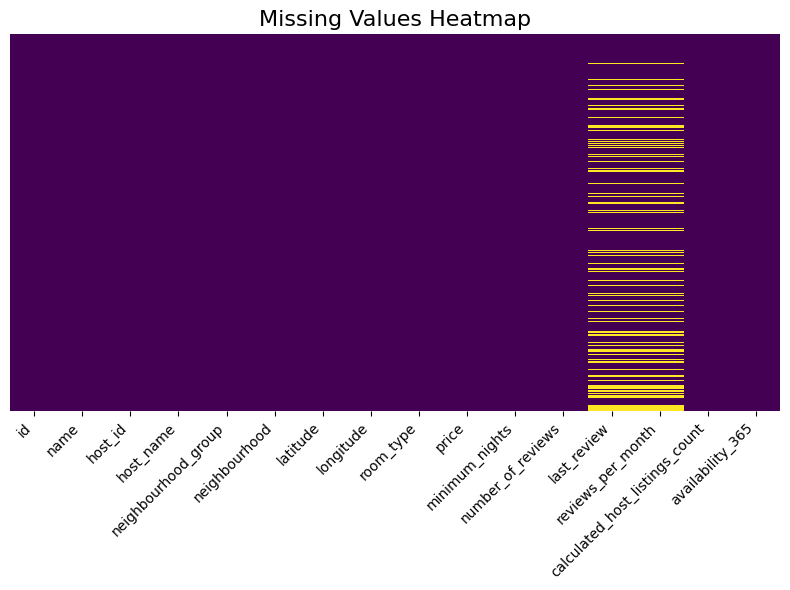

In [6]:
# Visualize missing values pattern
plt.figure(figsize=(8, 6)) 
sns.heatmap(df.isna(), cmap="viridis", yticklabels=False, cbar=False)
plt.title('Missing Values Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
# Check for duplicate records
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


> No duplicate records found in the dataset.

## Dataset Overview

This analysis uses the **AB_NYC_2019 dataset**, which contains 48,895 Airbnb listings with 16 features covering location, pricing, and guest reviews.

The target variable is **price** (nightly rate in USD, stored as integer). The dataset includes:
- **Numeric continuous:** latitude, longitude, reviews_per_month (float)
- **Numeric discrete:** minimum_nights, number_of_reviews, availability_365, calculated_host_listings_count (integers)
- **Categorical:** neighbourhood_group, neighbourhood, room_type
- **Temporal:** last_review (currently object, may convert to datetime)
- **Identifiers:** id, host_id, name, host_name

**Data Quality Check:**
- Missing values primarily in review columns (`last_review`, `reviews_per_month` at 20.56%), these likely represent listings without guest feedback yet
- Minimal missing in `name` and `host_name` (<0.05%)
- No duplicate records found

The next step is to explore the distribution of our target variable and identify potential outliers.

### Outcome Analysis

In [8]:
print(df['price'].describe())
print(f"\n99th percentile: ${df['price'].quantile(0.99):.2f}")
print(f"Max price: ${df['price'].max():.2f}")

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

99th percentile: $799.00
Max price: $10000.00


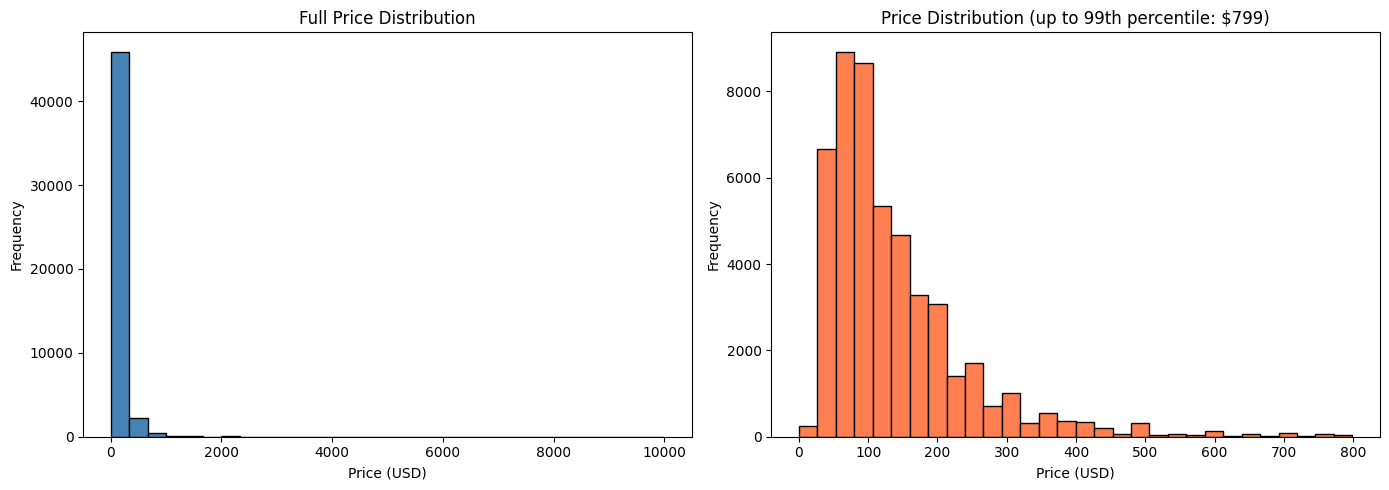

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Full distribution
axes[0].hist(df['price'], bins=30, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Price (USD)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Full Price Distribution')

# Right: Zoomed (up to 99th percentile for better view)
p99 = df['price'].quantile(0.99)
axes[1].hist(df[df['price'] <= p99]['price'], bins=30, color='coral', edgecolor='black')
axes[1].set_xlabel('Price (USD)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Price Distribution (up to 99th percentile: ${p99:.0f})')

plt.tight_layout()
plt.show()

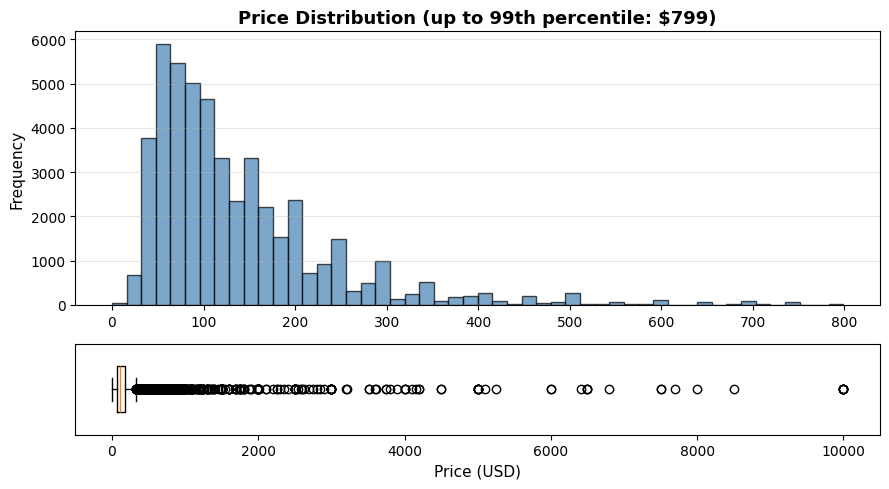

In [10]:
# NEW FIGURE - Price distribution with boxplot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 5),
                         gridspec_kw={'height_ratios': [3, 1]})

# Apply zoom to 99th percentile for better view
p99 = df['price'].quantile(0.99)
df_zoomed = df[df['price'] <= p99]

# Top: Histogram (zoomed)
axes[0].hist(df_zoomed['price'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(f'Price Distribution (up to 99th percentile: ${p99:.0f})', 
                  fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Bottom: Boxplot (full data to see outliers)
axes[1].boxplot(df['price'], vert=False, widths=0.5)
axes[1].set_xlabel('Price (USD)', fontsize=11)
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

In [11]:
# Check for zero prices
zero_count = (df['price'] == 0).sum()
zero_pct = (zero_count / len(df)) * 100
print(f"Listings with price = $0: {zero_count} ({zero_pct:.2f}%)")

Listings with price = $0: 11 (0.02%)


### Key Observations - Target Variable (Price)

**Distribution characteristics:**
- Right-skewed distribution with most listings concentrated in the $50-$150 range
- Peak frequency around $60-$100, which represents the typical nightly rate for NYC Airbnb listings
- Long tail extending beyond $800, indicating the presence of luxury/high-end properties

**Outliers are significant.** Multiple outliers detected above $800, with some reaching up to ~$10,000. The 99th percentile sits at $799, meaning only 1% of listings exceed this price. These likely represent luxury apartments, penthouses, or entire houses in premium Manhattan or Brooklyn locations.

**Data quality issues:**
- Found 11 listings with price = $0 (0.02% of dataset), likely data entry errors or incomplete listings that don't represent realistic rental prices
- These will be removed during preprocessing

**Implications for modeling:**
- The skewed distribution may affect linear models → log transformation could help normalize the data
- Outlier handling strategy needed: removal (exclude luxury segment), log transformation (compress extremes), or robust models (Random Forest, XGBoost)
- Final decision will be made during preprocessing based on model performance comparison and business context (do we need to predict luxury listings?)

---
> **Note on outliers:** During this univariate analysis, we identify variables with potential outliers but **do not remove them yet**. Outlier handling will be addressed in the preprocessing phase, where we'll experiment with:
1. Removal (price > $1000 or 99th percentile)
2. Log transformation
3. Robust models (Random Forest, XGBoost)

Decision will be based on model performance comparison.

---

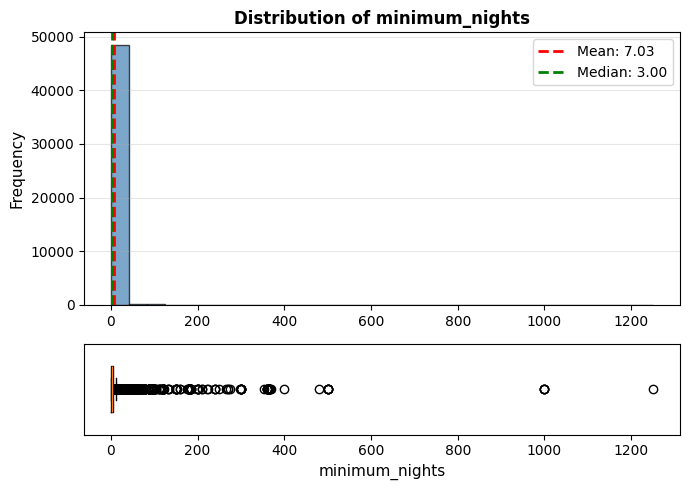


MINIMUM_NIGHTS - Statistics:
count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64
Missing values: 0 (0.00%)
------------------------------------------------------------


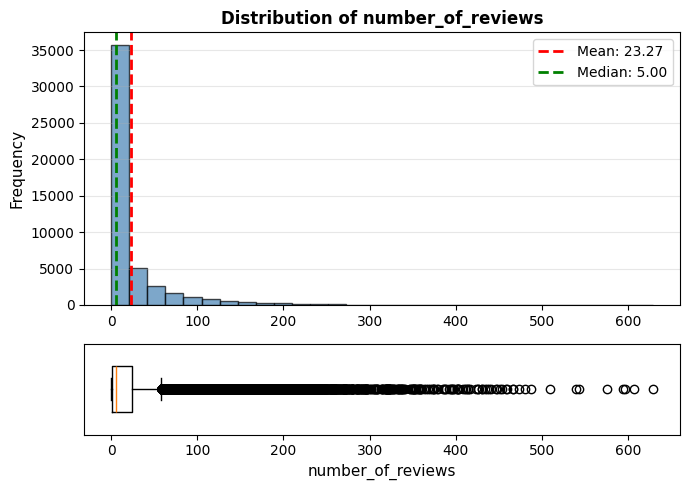


NUMBER_OF_REVIEWS - Statistics:
count    48895.000000
mean        23.274466
std         44.550582
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: number_of_reviews, dtype: float64
Missing values: 0 (0.00%)
------------------------------------------------------------


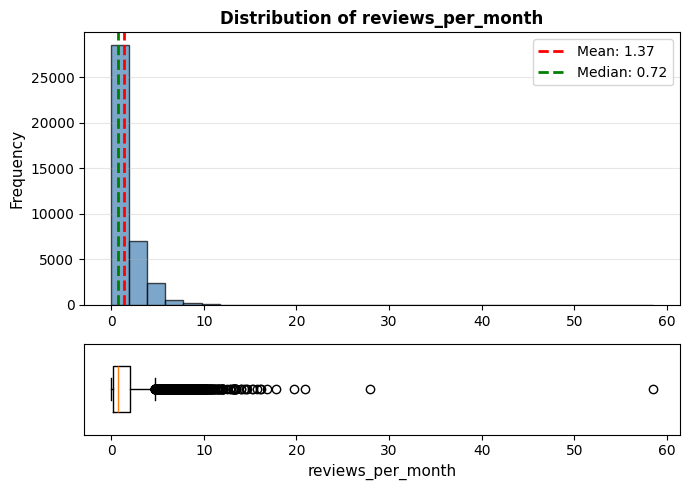


REVIEWS_PER_MONTH - Statistics:
count    38843.000000
mean         1.373221
std          1.680442
min          0.010000
25%          0.190000
50%          0.720000
75%          2.020000
max         58.500000
Name: reviews_per_month, dtype: float64
Missing values: 10052 (20.56%)
------------------------------------------------------------


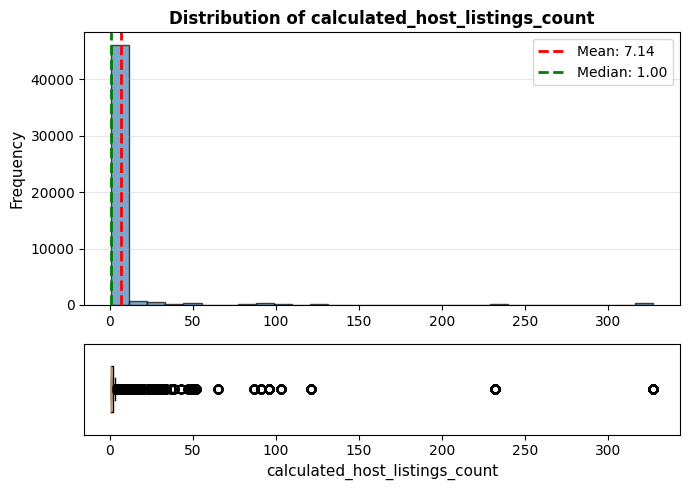


CALCULATED_HOST_LISTINGS_COUNT - Statistics:
count    48895.000000
mean         7.143982
std         32.952519
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64
Missing values: 0 (0.00%)
------------------------------------------------------------


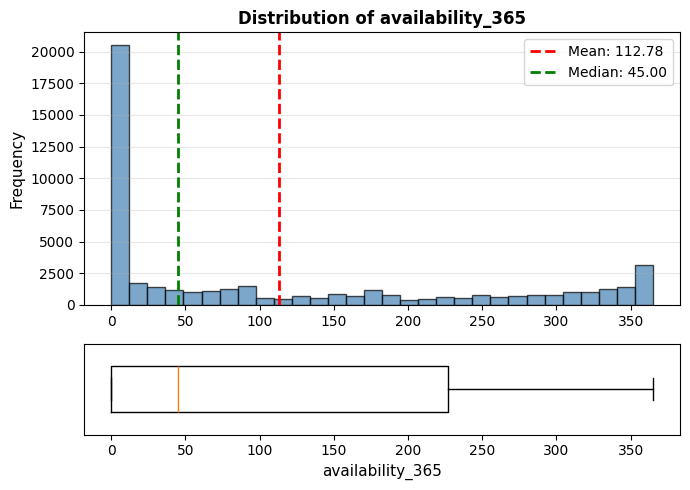


AVAILABILITY_365 - Statistics:
count    48895.000000
mean       112.781327
std        131.622289
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: availability_365, dtype: float64
Missing values: 0 (0.00%)
------------------------------------------------------------


In [12]:
# UNIVARIATE ANALYSIS - NUMERIC FEATURES

numeric_cols = ['minimum_nights', 
                'number_of_reviews', 'reviews_per_month', 
                'calculated_host_listings_count', 'availability_365']

for col in numeric_cols:
    # Create figure with 2 subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 5),
                             gridspec_kw={'height_ratios': [3, 1]})
    
    # Top: Histogram
    axes[0].hist(df[col].dropna(), bins=30, color='steelblue', 
                 edgecolor='black', alpha=0.7)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add mean/median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[0].axvline(mean_val, color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[0].axvline(median_val, color='green', linestyle='--', 
                    linewidth=2, label=f'Median: {median_val:.2f}')
    axes[0].legend()
    
    # Bottom: Boxplot
    axes[1].boxplot(df[col].dropna(), vert=False, widths=0.5)
    axes[1].set_xlabel(col, fontsize=11)
    axes[1].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Print stats for this column
    print(f"\n{col.upper()} - Statistics:")
    print(df[col].describe())
    print(f"Missing values: {df[col].isna().sum()} ({df[col].isna().sum()/len(df)*100:.2f}%)")
    print("-"*60)

### Key Observations - Numeric Features

All numeric features show **right-skewed distributions with significant outliers.** The consistent gap between means and medians confirms this pattern across the board.

**Review activity:**
- Median of 5 reviews per listing, but mean of 23 (pulled by highly-reviewed properties up to 629 reviews)
- 20.56% missing in `reviews_per_month` - these are listings without any guest feedback yet
- Average review rate is 1.37 per month, though median sits at 0.72

Most listings receive relatively few reviews, which is typical for platforms with many new or occasional rentals alongside established properties.

**Minimum nights and availability:**
- Median requirement is 3 nights, with 75% of hosts allowing 5 nights or less
- Extreme outliers exist (max = 1,250 nights), likely data errors or special long-term arrangements
- Availability ranges from 0 to 365 days per year (median = 45 days)
- 25% report zero availability - either fully booked or inactive calendars

This variation in availability suggests diverse host strategies, from occasional rentals to full-time operations.

**Preprocessing implications:** The extreme outliers in `minimum_nights` need attention before modeling. Other features show typical skewness patterns that can be handled with standard preprocessing techniques or robust model selection.

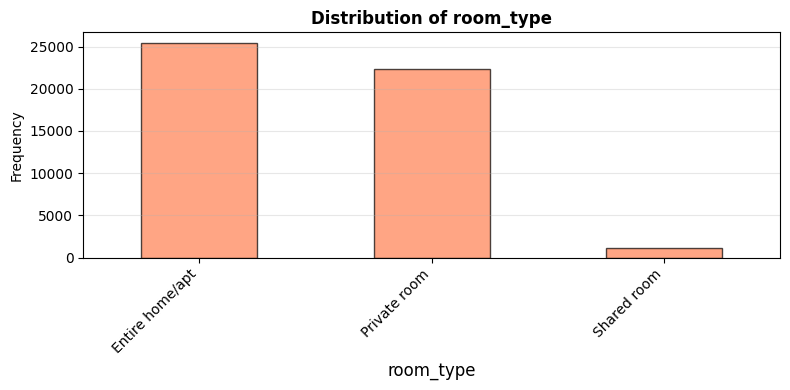


ROOM_TYPE - Summary:
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64
Percentage distribution:
room_type
Entire home/apt    51.97
Private room       45.66
Shared room         2.37
Name: count, dtype: float64%
------------------------------------------------------------


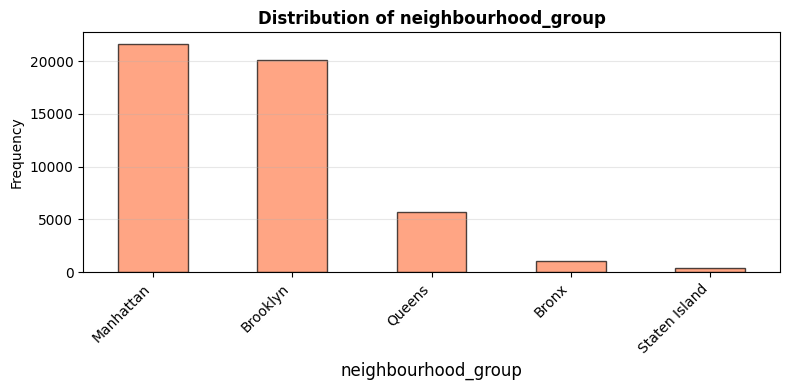


NEIGHBOURHOOD_GROUP - Summary:
neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64
Percentage distribution:
neighbourhood_group
Manhattan        44.30
Brooklyn         41.12
Queens           11.59
Bronx             2.23
Staten Island     0.76
Name: count, dtype: float64%
------------------------------------------------------------


In [13]:
# UNIVARIATE ANALYSIS - CATEGORICAL FEATURES

categorical_cols = ['room_type', 'neighbourhood_group']

for col in categorical_cols:
    value_counts = df[col].value_counts()
    
    plt.figure(figsize=(8, 4))
    value_counts.plot(kind='bar', color='coral', edgecolor='black', alpha=0.7)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{col.upper()} - Summary:")
    print(value_counts)
    print(f"Percentage distribution:\n{(value_counts/len(df)*100).round(2)}%")
    print("-"*60)

Total unique neighbourhoods: 221

Top 15 neighbourhoods by listing count:
neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
East Harlem           1117
Greenpoint            1115
Chelsea               1113
Lower East Side        911
Astoria                900
Name: count, dtype: int64


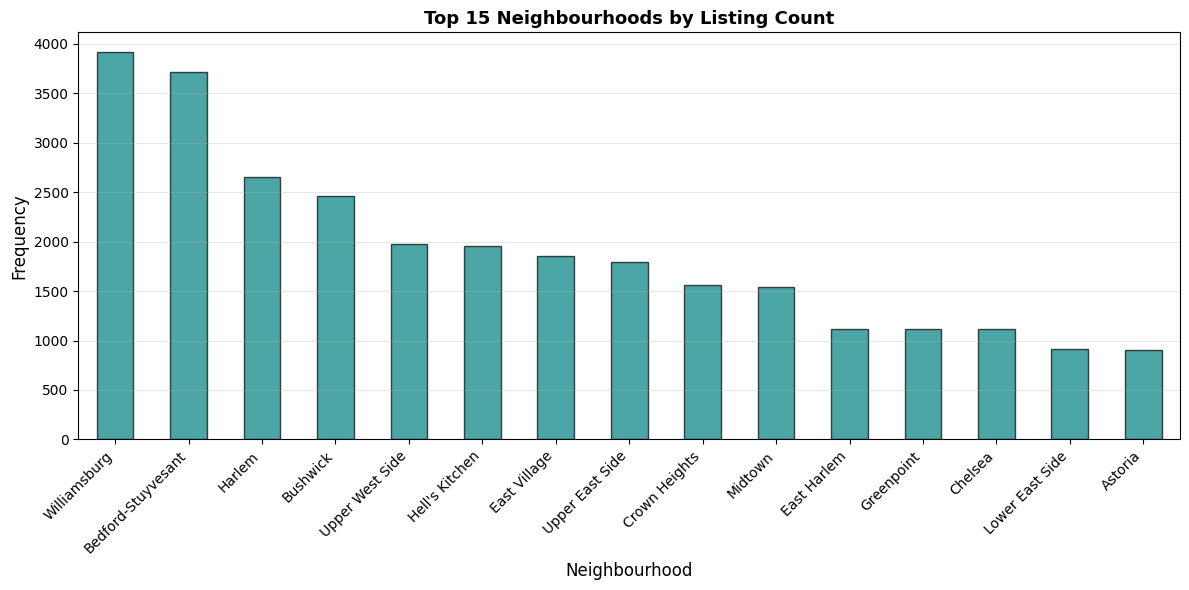

In [14]:
# neighbourhood has 221 unique values - too many for one bar plot
print(f"Total unique neighbourhoods: {df['neighbourhood'].nunique()}")
print(f"\nTop 15 neighbourhoods by listing count:")
print(df['neighbourhood'].value_counts().head(15))

# Plot only top 15
plt.figure(figsize=(12, 6))
df['neighbourhood'].value_counts().head(15).plot(kind='bar', color='teal', edgecolor='black', alpha=0.7)
plt.xlabel('Neighbourhood', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Top 15 Neighbourhoods by Listing Count', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Convert to datetime
df['last_review_dt'] = pd.to_datetime(df['last_review'], errors='coerce')

# Summary
print(f"Last review date range:")
print(f"Earliest: {df['last_review_dt'].min()}")
print(f"Latest: {df['last_review_dt'].max()}")
print(f"Missing: {df['last_review_dt'].isna().sum()} ({df['last_review_dt'].isna().sum()/len(df)*100:.2f}%)")

Last review date range:
Earliest: 2011-03-28 00:00:00
Latest: 2019-07-08 00:00:00
Missing: 10052 (20.56%)


### Key Observations - Categorical Features

**Room type distribution:**
- Entire home/apt dominates with 51.97% of listings (25,409 units)
- Private rooms represent 45.66% (22,326 listings)
- Shared rooms are minimal at 2.37% (1,160 listings)

The near-even split between entire homes and private rooms suggests a diverse market serving both tourists seeking full apartments and budget travelers looking for private accommodations. The low percentage of shared rooms indicates this type is less popular or less commonly offered in NYC.

**Geographic distribution (neighbourhood_group):**
- Manhattan and Brooklyn dominate the dataset, accounting for 85.4% of all listings (44.3% and 41.1% respectively)
- Queens represents 11.6%, while Bronx (2.2%) and Staten Island (0.8%) have minimal presence

This concentration reflects Manhattan and Brooklyn as the primary Airbnb destinations in NYC, likely driven by tourism, attractions, and transportation accessibility.

**Neighbourhood diversity:**
Total of 221 unique neighbourhoods across NYC shows high geographic granularity. The top 3 are Williamsburg (3,920 listings), Bedford-Stuyvesant (3,714), and Harlem (2,658). Williamsburg alone accounts for around 8% of all listings, indicating strong clustering in popular Brooklyn neighborhoods. The long tail suggests many areas have very few listings and may need grouping during preprocessing.

**Temporal data (last_review):**
Review dates span from March 2011 to July 2019 (8+ years of activity). Missing values at 10,052 listings (20.56%) are consistent with new or inactive listings without guest reviews yet. The latest review date (July 2019) aligns with the dataset name, suggesting this is a mid-2019 snapshot.

## Bivariate Analysis

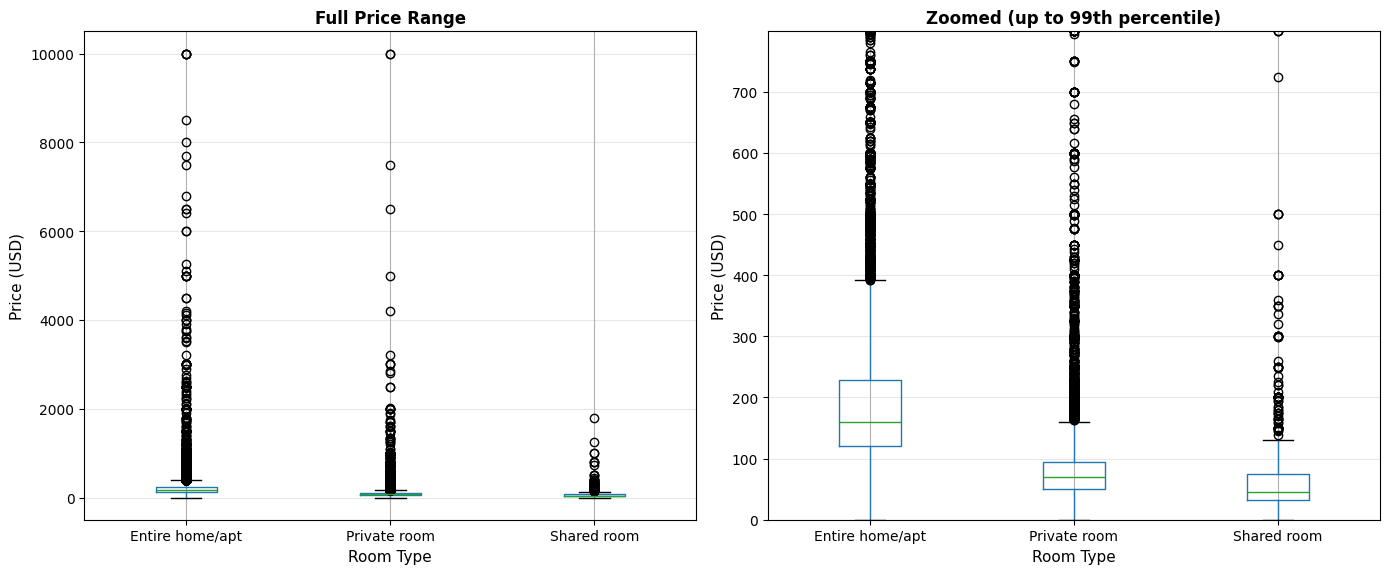

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Full data
df.boxplot(column='price', by='room_type', ax=axes[0])
axes[0].set_xlabel('Room Type', fontsize=11)
axes[0].set_ylabel('Price (USD)', fontsize=11)
axes[0].set_title('Full Price Range', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Right: Zoomed (99th percentile)
df.boxplot(column='price', by='room_type', ax=axes[1])
axes[1].set_xlabel('Room Type', fontsize=11)
axes[1].set_ylabel('Price (USD)', fontsize=11)
axes[1].set_title('Zoomed (up to 99th percentile)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, df['price'].quantile(0.99))
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('')
plt.tight_layout()
plt.show()

In [17]:
# Summary statistics
print("Price by Room Type - Summary Statistics:")
print(df.groupby('room_type')['price'].agg(['count', 'mean', 'median', 'max']))

Price by Room Type - Summary Statistics:
                 count        mean  median    max
room_type                                        
Entire home/apt  25409  211.794246   160.0  10000
Private room     22326   89.780973    70.0  10000
Shared room       1160   70.127586    45.0   1800


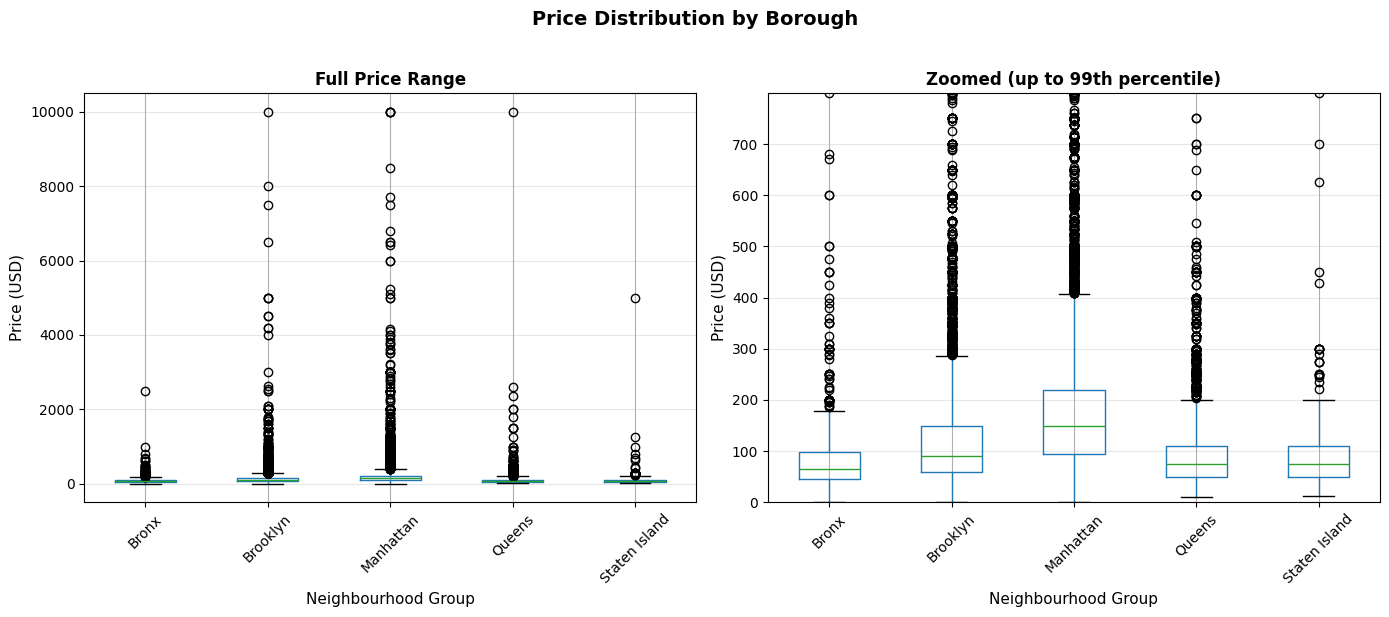

Price by Neighbourhood Group - Summary Statistics:
                     count        mean  median    max
neighbourhood_group                                  
Bronx                 1091   87.496792    65.0   2500
Brooklyn             20104  124.383207    90.0  10000
Manhattan            21661  196.875814   150.0  10000
Queens                5666   99.517649    75.0  10000
Staten Island          373  114.812332    75.0   5000


In [18]:
# ========================================
# BIVARIATE ANALYSIS - Price vs Neighbourhood Group
# ========================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Full data
df.boxplot(column='price', by='neighbourhood_group', ax=axes[0])
axes[0].set_xlabel('Neighbourhood Group', fontsize=11)
axes[0].set_ylabel('Price (USD)', fontsize=11)
axes[0].set_title('Full Price Range', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Right: Zoomed (99th percentile)
df.boxplot(column='price', by='neighbourhood_group', ax=axes[1])
axes[1].set_xlabel('Neighbourhood Group', fontsize=11)
axes[1].set_ylabel('Price (USD)', fontsize=11)
axes[1].set_title('Zoomed (up to 99th percentile)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, df['price'].quantile(0.99))
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Price Distribution by Borough', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary statistics
print("Price by Neighbourhood Group - Summary Statistics:")
print(df.groupby('neighbourhood_group')['price'].agg(['count', 'mean', 'median', 'max']))

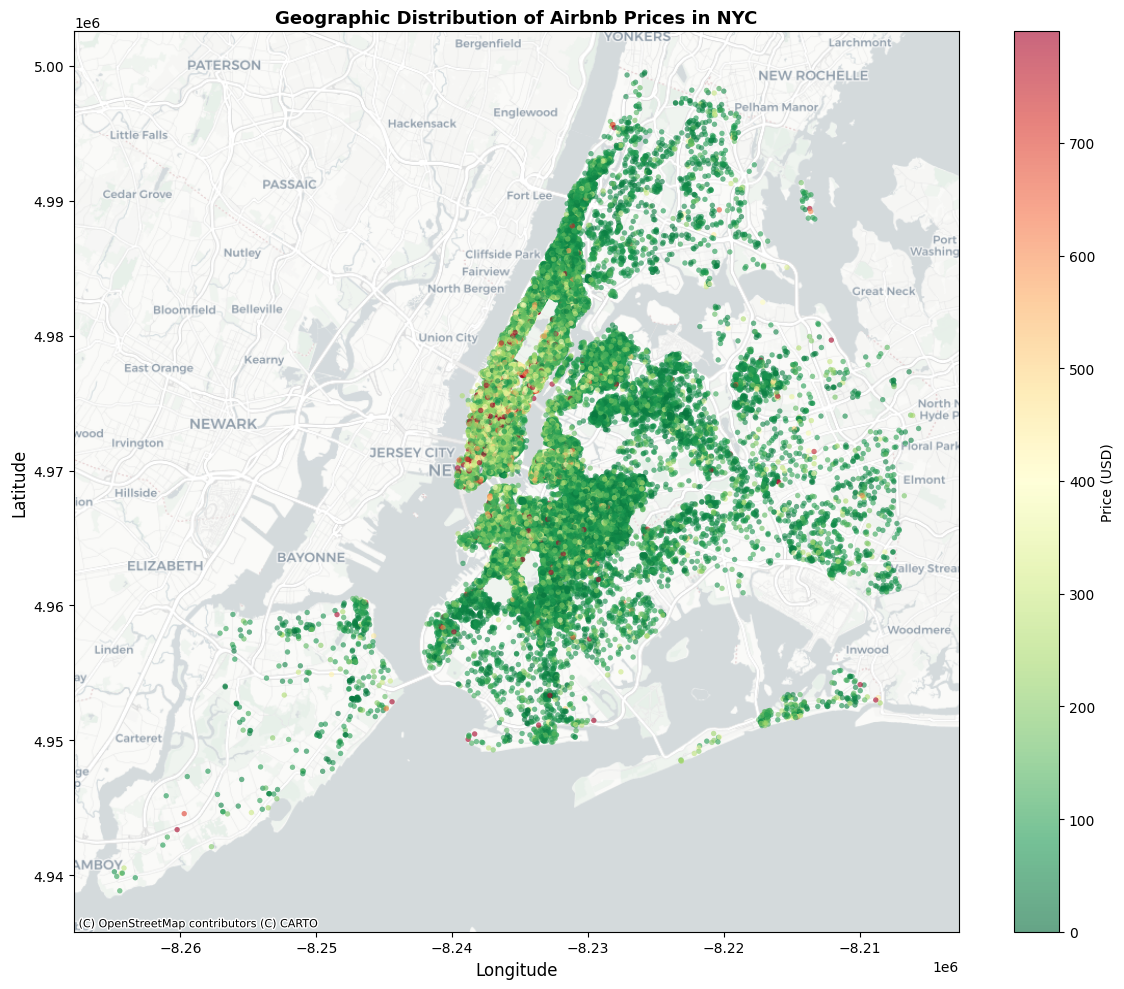

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
df['x'], df['y'] = transformer.transform(df['longitude'].values, df['latitude'].values)

# Scatter plot
scatter = ax.scatter(df['x'], df['y'], 
                    c=df['price'], 
                    cmap='RdYlGn_r',
                    alpha=0.6,
                    s=15,
                    edgecolors='none',
                    vmin=0,
                    vmax=df['price'].quantile(0.99))

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.colorbar(scatter, label='Price (USD)', ax=ax)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Geographic Distribution of Airbnb Prices in NYC', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

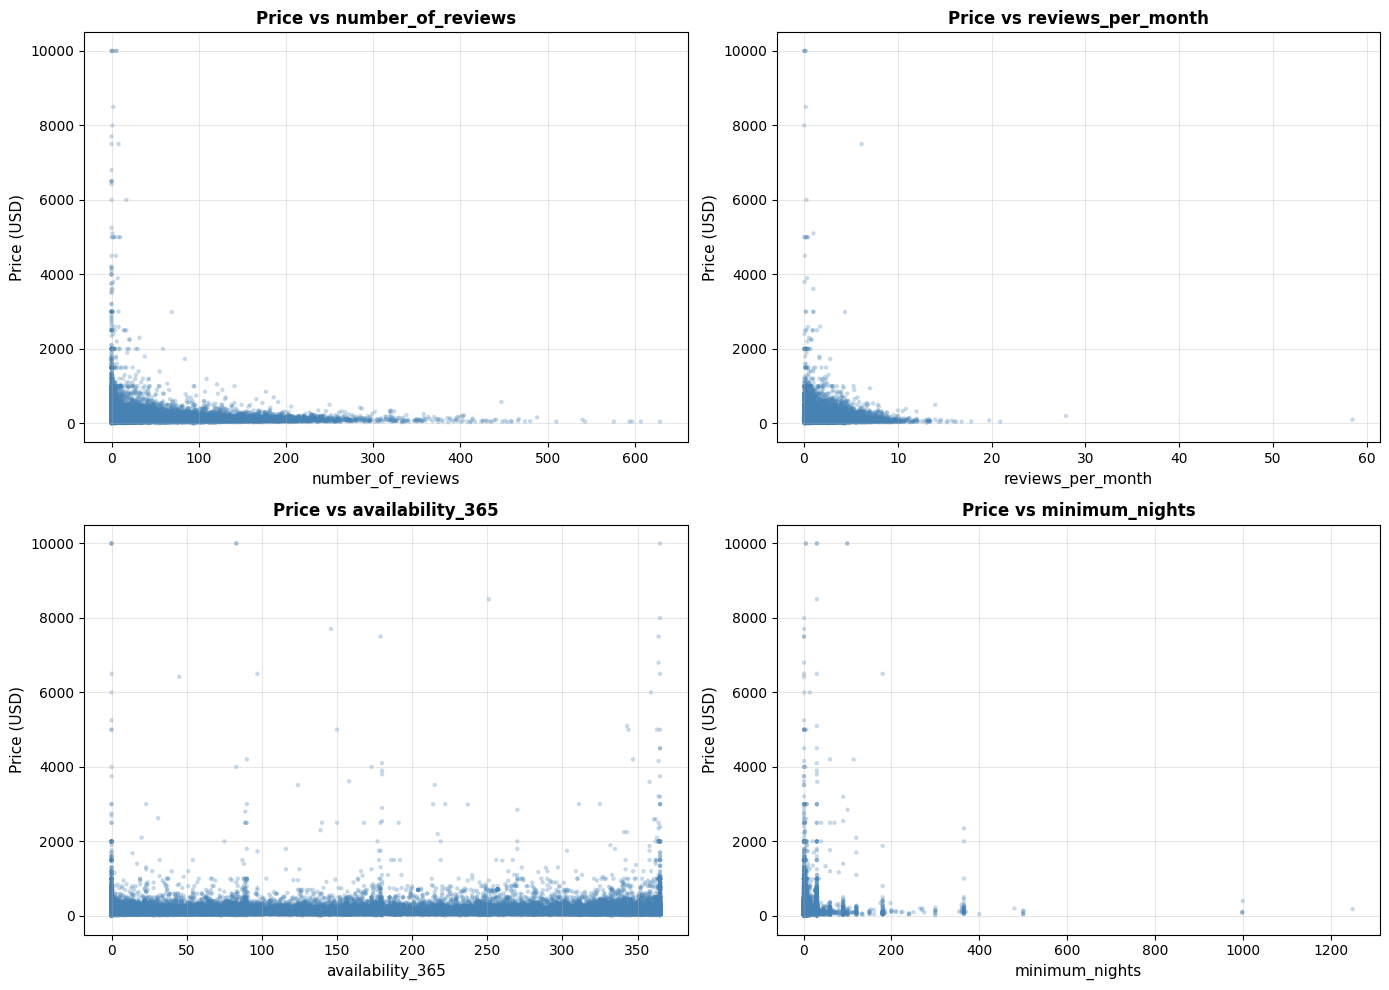

CORRELATION WITH PRICE
number_of_reviews             : -0.048
reviews_per_month             : -0.031
availability_365              :  0.082
minimum_nights                :  0.043


In [29]:
# ========================================
# BIVARIATE ANALYSIS - Price vs Numeric Features
# ========================================

numeric_features = ['number_of_reviews', 'reviews_per_month', 
                   'availability_365', 'minimum_nights']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(df[feature], df['price'], alpha=0.3, s=10, color='steelblue', edgecolors='none')
    
    # Labels
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Price (USD)', fontsize=11)
    ax.set_title(f'Price vs {feature}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlations
print("="*60)
print("CORRELATION WITH PRICE")
print("="*60)
for feature in numeric_features:
    corr = df[[feature, 'price']].corr().iloc[0, 1]
    print(f"{feature:30s}: {corr:6.3f}")